In [4]:
import os, numpy as np, pandas as pd
from glob import glob
from saspt import StateArray, StateArrayDataset, RBME, load_detections
import re
from matplotlib import pyplot as plt

In [5]:
# read in all files from the dataset, and perform a StateArray analysis on the combined data.

# This assumes that you have classified cells into just one category. The code will need to be modified for additional categories.
input_files = glob('cell_by_cell_csvs_all/1/*csv')
detections = load_detections(*input_files)
settings = dict(
    likelihood_type = RBME,
    pixel_size_um = 0.16,
    frame_interval = 0.00748,
    focal_depth = 0.7,
    start_frame = 0,
    progress_bar = True,
    sample_size = 1e6,
)
SA = StateArray.from_detections(detections, **settings)
print(SA)
print("Trajectory statistics:")
for k, v in SA.trajectories.processed_track_statistics.items():
    print(f"{k : <20} : {v}")

StateArray:
  likelihood_type   : rbme
  n_tracks          : 82453
  n_jumps           : 405616
  parameter_names   : ('diff_coef', 'loc_error')
  shape             : (100, 36)
Trajectory statistics:
n_tracks             : 82453
n_jumps              : 405616
n_detections         : 488069
mean_track_length    : 5.919360120310965
max_track_length     : 11
fraction_singlets    : 0.0
fraction_unassigned  : 0.0
mean_jumps_per_track : 4.919360120310965
mean_detections_per_frame : 81.34483333333333
max_detections_per_frame : 167
fraction_of_frames_with_detections : 1.0


In [6]:
# make some output plots, and write the overall posterior occupations to a CSV file

SA.occupations_dataframe.to_csv("posterior_occupations.csv", index=False)
SA.plot_occupations("posterior_occupations.png")
SA.plot_assignment_probabilities("assignment_probabilities.png")
SA.plot_temporal_assignment_probabilities("assignment_probabilities_by_frame.png")

  0%|          | 0/200 [00:00<?, ?it/s]

inferring posterior distribution...


100%|██████████| 200/200 [42:22<00:00, 12.71s/it]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [8]:
po = pd.read_csv('posterior_occupations.csv')

/root/anaconda3/envs/quot_env2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/root/anaconda3/envs/quot_env2/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


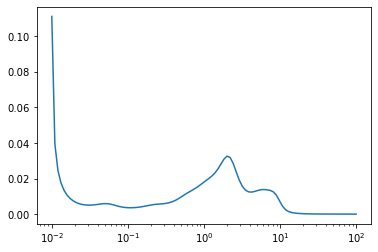

In [13]:
grouped = po.groupby('diff_coef',as_index=False).sum()
D = grouped['diff_coef'].to_numpy()
mpo = grouped['mean_posterior_occupation']
plt.semilogx(D,mpo)

In [7]:
# write out StateArray as a pickled file

import pickle
with open('SA_pickle','wb') as fh:
    pickle.dump(SA,fh)